In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, skew, kurtosis

In [ ]:
from google.colab import files
upload = files.upload()

Saving Agrofood_co2_emission.csv to Agrofood_co2_emission.csv


In [ ]:
df = pd.read_csv('Agrofood_co2_emission.csv')
df.head()

,Area,Year,Savanna fires,Forest fires,Crop Residues,Rice Cultivation,Drained organic soils (CO2),Pesticides Manufacturing,Food Transport,Forestland,...,Manure Management,Fires in organic soils,Fires in humid tropical forests,On-farm energy use,Rural population,Urban population,Total Population - Male,Total Population - Female,total_emission,Average Temperature °C
0,Afghanistan,1990,14.7237,0.0557,205.6077,686.00,0.0,11.807483,63.1152,-2388.803,...,319.1763,0.0,0.0,NaN,9655167.0,2593947.0,5348387.0,5346409.0,2198.963539,0.536167
1,Afghanistan,1991,14.7237,0.0557,209.4971,678.16,0.0,11.712073,61.2125,-2388.803,...,342.3079,0.0,0.0,NaN,10230490.0,2763167.0,5372959.0,5372208.0,2323.876629,0.020667
2,Afghanistan,1992,14.7237,0.0557,196.5341,686.00,0.0,11.712073,53.3170,-2388.803,...,349.1224,0.0,0.0,NaN,10995568.0,2985663.0,6028494.0,6028939.0,2356.304229,-0.259583
3,Afghanistan,1993,14.7237,0.0557,230.8175,686.00,0.0,11.712073,54.3617,-2388.803,...,352.2947,0.0,0.0,NaN,11858090.0,3237009.0,7003641.0,7000119.0,2368.470529,0.101917
4,Afghanistan,1994,14.7237,0.0557,242.0494,705.60,0.0,11.712073,53.9874,-2388.803,...,367.6784,0.0,0.0,NaN,12690115.0,3482604.0,7733458.0,7722096.0,2500.768729,0.372250


In [ ]:
#Check for Duplicates
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Area                             6965 non-null   object 
 1   Year                             6965 non-null   int64  
 2   Savanna fires                    6934 non-null   float64
 3   Forest fires                     6872 non-null   float64
 4   Crop Residues                    5576 non-null   float64
 5   Rice Cultivation                 6965 non-null   float64
 6   Drained organic soils (CO2)      6965 non-null   float64
 7   Pesticides Manufacturing         6965 non-null   float64
 8   Food Transport                   6965 non-null   float64
 9   Forestland                       6472 non-null   float64
 10  Net Forest conversion            6472 non-null   float64
 11  Food Household Consumption       6492 non-null   float64
 12  Food Retail         

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).sort_values('Missing Values', ascending=False)

print(missing_info[missing_info['Missing Values'] > 0])

                                 Missing Values  Percentage
Crop Residues                              1389   19.942570
On-farm energy use                          956   13.725772
Manure Management                           928   13.323762
Manure applied to Soils                     928   13.323762
IPPU                                        743   10.667624
Forestland                                  493    7.078248
Net Forest conversion                       493    7.078248
Food Household Consumption                  473    6.791098
Fires in humid tropical forests             155    2.225413
Forest fires                                 93    1.335248
Savanna fires                                31    0.445083


In [ ]:
# Handle missing values from IPPU
def handle_missing_values(df):
    df_clean = df.copy()

    # For 'IPPU' - medium missing rate, impute with median by country
    df_clean['IPPU'] = df_clean.groupby('Area')['IPPU'].transform(lambda x: x.fillna(x.median()))

    # Fill any remaining missing values with 0
    df_clean = df_clean.fillna(0)

    return df_clean

# Apply missing value handling
df_clean = handle_missing_values(df)
print("Missing values after handling:", df_clean.isnull().sum().sum())

Missing values after handling: 0


In [ ]:
# Check for unrealistic values
def data_quality_check(df_clean):
    quality_issues = []

    # Check for negative values in emissions (should be non-negative)
    emission_columns = [col for col in df_clean.columns if col not in ['Area', 'Year', 'Average Temperature °C', 'Rural population', 'Urban population', 'Total Population - Male', 'Total Population - Female']]
    negative_counts = {}
    for col in emission_columns:
        negative_count = (df_clean[col] < 0).sum()
        if negative_count > 0:
            negative_counts[col] = negative_count
            quality_issues.append(f"{col}: {negative_count} negative values")

    # Check for extreme outliers (beyond 5 standard deviations)
    outlier_issues = []
    for col in emission_columns:
        if df_clean[col].std() > 0:  # Avoid division by zero
            z_scores = np.abs((df_clean[col] - df_clean[col].mean()) / df_clean[col].std()) #Zscores checking how far it is from standard deviation
            extreme_outliers = (z_scores > 5).sum()
            if extreme_outliers > 0:
                outlier_issues.append(f"{col}: {extreme_outliers} extreme outliers")

    return quality_issues, outlier_issues, negative_counts

quality_issues, outlier_issues, negative_counts = data_quality_check(df_clean)

print("Data Quality Issues:")
for issue in quality_issues:
    print(f"  - {issue}")

print("\nExtreme Outliers:")
for issue in outlier_issues:
    print(f"  - {issue}")

Data Quality Issues:
  - Forestland: 4224 negative values
  - total_emission: 238 negative values

Extreme Outliers:
  - Savanna fires: 35 extreme outliers
  - Forest fires: 94 extreme outliers
  - Crop Residues: 113 extreme outliers
  - Rice Cultivation: 93 extreme outliers
  - Drained organic soils (CO2): 33 extreme outliers
  - Pesticides Manufacturing: 89 extreme outliers
  - Food Transport: 53 extreme outliers
  - Forestland: 103 extreme outliers
  - Net Forest conversion: 52 extreme outliers
  - Food Household Consumption: 41 extreme outliers
  - Food Retail: 57 extreme outliers
  - On-farm Electricity Use: 83 extreme outliers
  - Food Packaging: 49 extreme outliers
  - Agrifood Systems Waste Disposal: 92 extreme outliers
  - Food Processing: 73 extreme outliers
  - Fertilizers Manufacturing: 61 extreme outliers
  - IPPU: 49 extreme outliers
  - Manure applied to Soils: 64 extreme outliers
  - Manure left on Pasture: 108 extreme outliers
  - Manure Management: 95 extreme outliers

In [ ]:
#Outlier checking
def Outlier_quality_check(df_clean):
    emission_columns = [col for col in df_clean.columns if col not in ['Area', 'Year', 'Average Temperature °C', 'Rural population', 'Urban population', 'Total Population - Male', 'Total Population - Female']]

    outlier_report = []

    for col in emission_columns:
        # Skip columns with no variation
        if df_clean[col].std() == 0:
            continue

        # Method 1: IQR (Interquartile Range)
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound_iqr = Q1 - 1.5 * IQR
        upper_bound_iqr = Q3 + 1.5 * IQR

        iqr_outliers = df_clean[(df_clean[col] < lower_bound_iqr) | (df_clean[col] > upper_bound_iqr)]
        iqr_count = len(iqr_outliers)


        # Get actual outlier values with context
        if iqr_count > 0:
            outlier_details = iqr_outliers[['Area', 'Year', col]].copy()
            outlier_details['Method'] = 'IQR'
            outlier_details['Column'] = col
            outlier_details['Bounds'] = f"({lower_bound_iqr:.2f}, {upper_bound_iqr:.2f})"

            outlier_report.append(outlier_details)

        # Add column summary to report
        col_summary = {
            'Column': col,
            'IQR_Outliers': iqr_count,
            'IQR_Bounds': f"({lower_bound_iqr:.2f}, {upper_bound_iqr:.2f})",
            'Mean': df_clean[col].mean(),
            'Median': df_clean[col].median(),
            'Std': df_clean[col].std(),
            'Min': df_clean[col].min(),
            'Max': df_clean[col].max()
        }

        outlier_report.append(col_summary)

    return outlier_report

# Run the analysis
outlier_report = Outlier_quality_check(df_clean)

# Print detailed results
print("=== OUTLIER ANALYSIS REPORT ===\n")

# Separate summary and details
summaries = [item for item in outlier_report if isinstance(item, dict)]
details = [item for item in outlier_report if not isinstance(item, dict)]

# Print column summaries
print("COLUMN SUMMARIES:")
print("-" * 80)
for summary in summaries:
    print(f"\nColumn: {summary['Column']}")
    print(f"  IQR Outliers: {summary['IQR_Outliers']} (bounds: {summary['IQR_Bounds']})")
    print(f"  Stats: Mean={summary['Mean']:.2f}, Median={summary['Median']:.2f}, Std={summary['Std']:.2f}, Range=[{summary['Min']:.2f}, {summary['Max']:.2f}]")



=== OUTLIER ANALYSIS REPORT ===

COLUMN SUMMARIES:
--------------------------------------------------------------------------------

Column: Savanna fires
  IQR Outliers: 1439 (bounds: (-162.54, 270.90))
  Stats: Mean=1183.10, Median=1.59, Std=5235.20, Range=[0.00, 114616.40]

Column: Forest fires
  IQR Outliers: 1412 (bounds: (-91.86, 153.09))
  Stats: Mean=907.03, Median=0.42, Std=3696.66, Range=[0.00, 52227.63]

Column: Crop Residues
  IQR Outliers: 1021 (bounds: (-397.01, 661.75))
  Stats: Mean=799.54, Median=43.00, Std=3334.78, Range=[0.00, 33490.07]

Column: Rice Cultivation
  IQR Outliers: 923 (bounds: (-1851.81, 3569.71))
  Stats: Mean=4259.67, Median=534.82, Std=17613.83, Range=[0.00, 164915.26]

Column: Drained organic soils (CO2)
  IQR Outliers: 1361 (bounds: (-1035.61, 1726.02))
  Stats: Mean=3503.23, Median=0.00, Std=15861.45, Range=[0.00, 241025.07]

Column: Pesticides Manufacturing
  IQR Outliers: 946 (bounds: (-159.49, 281.81))
  Stats: Mean=333.42, Median=13.00, Std=14

Creating comprehensive outlier visualizations...
Plotting 24 emission columns...


/tmp/ipython-input-1068020438.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(plot_data, labels=labels, patch_artist=True, showfliers=True)


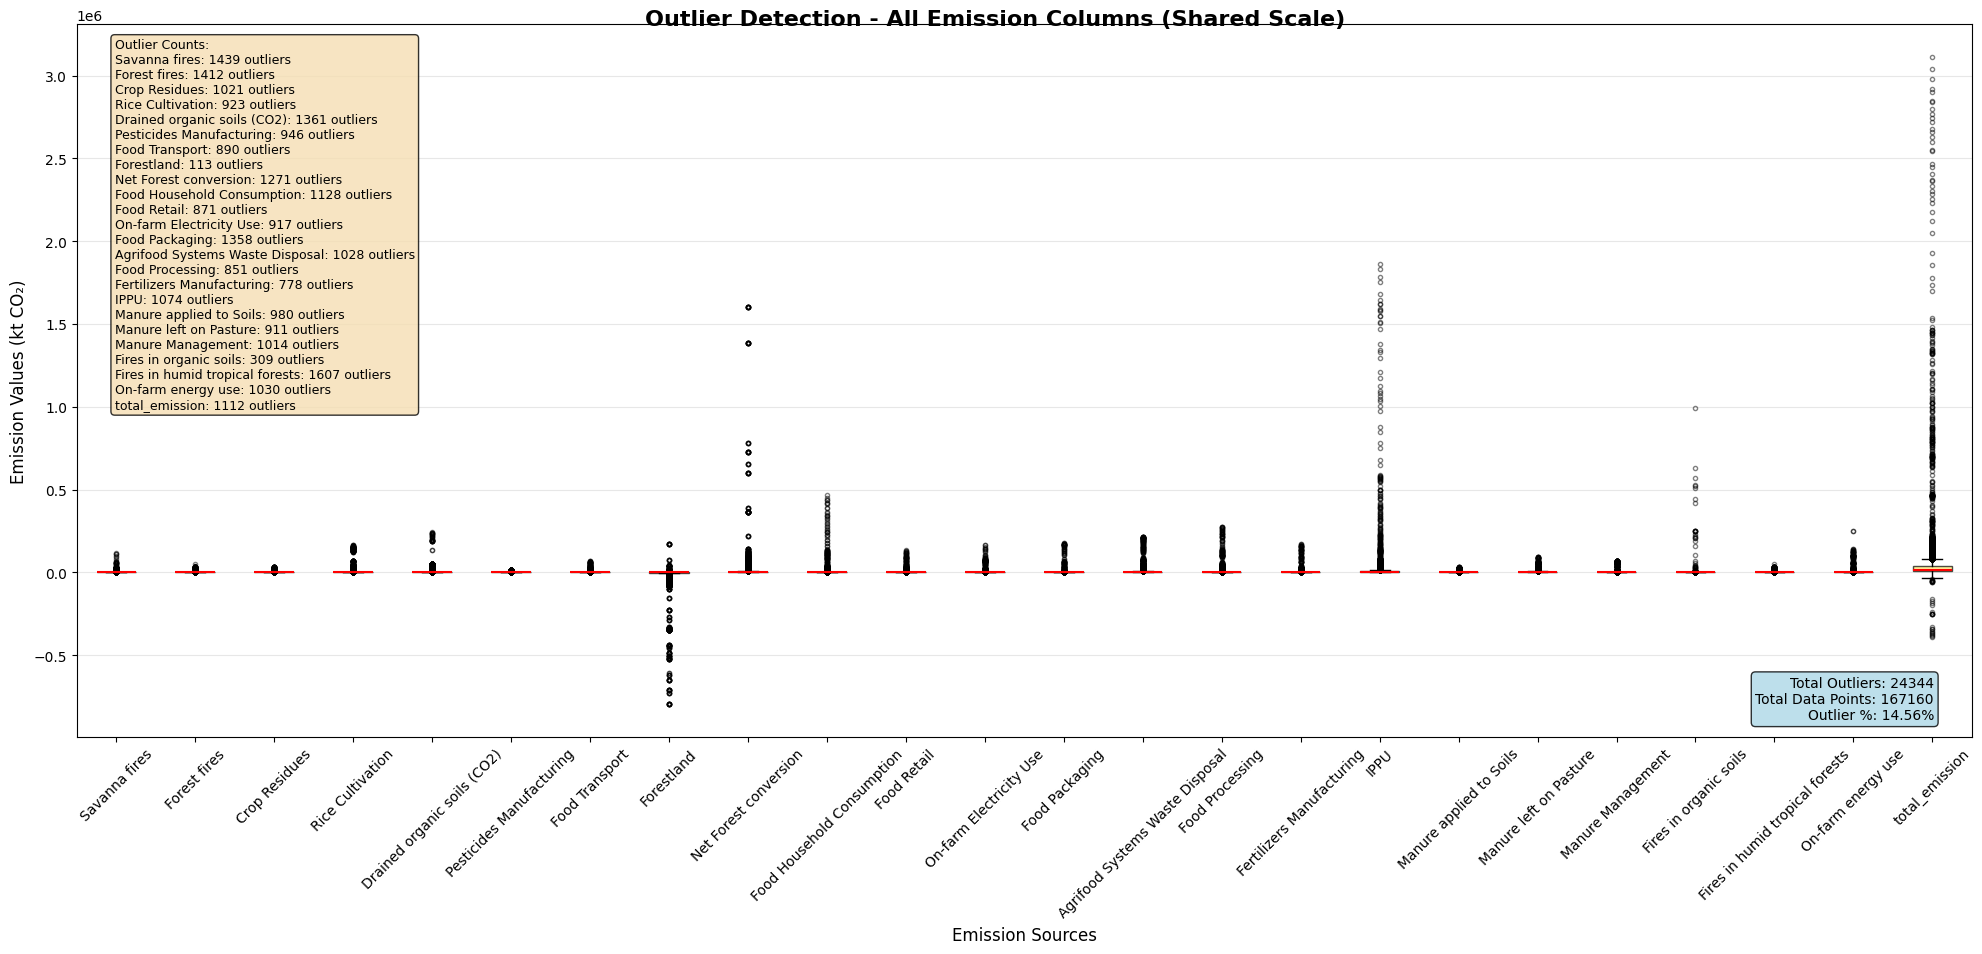

Plotting 22 emission columns (log scale)...


/tmp/ipython-input-1068020438.py:133: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = ax.boxplot(plot_data, labels=labels, patch_artist=True, showfliers=True)


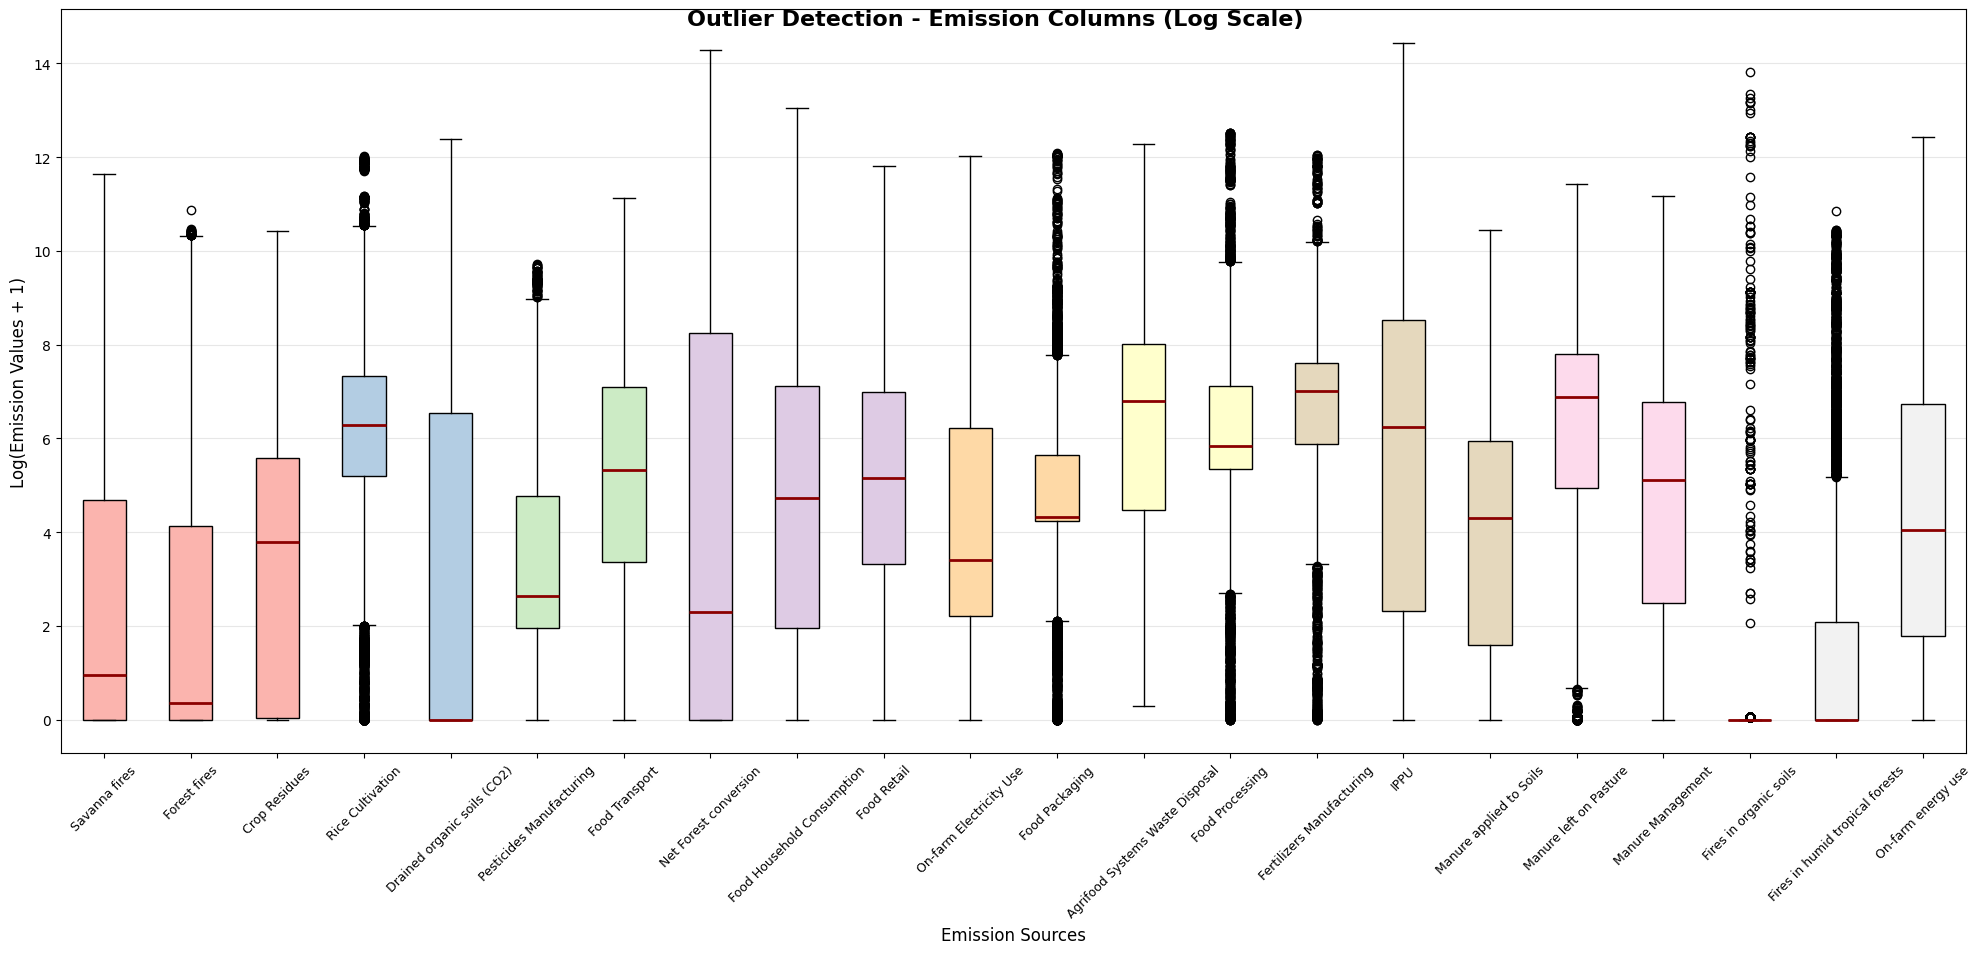

/tmp/ipython-input-1068020438.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = axes[idx].boxplot(plot_data, labels=available_cols, patch_artist=True)
/tmp/ipython-input-1068020438.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = axes[idx].boxplot(plot_data, labels=available_cols, patch_artist=True)
/tmp/ipython-input-1068020438.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = axes[idx].boxplot(plot_data, labels=available_cols, patch_artist=True)
/tmp/ipython-input-1068020438.py:195: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_lab

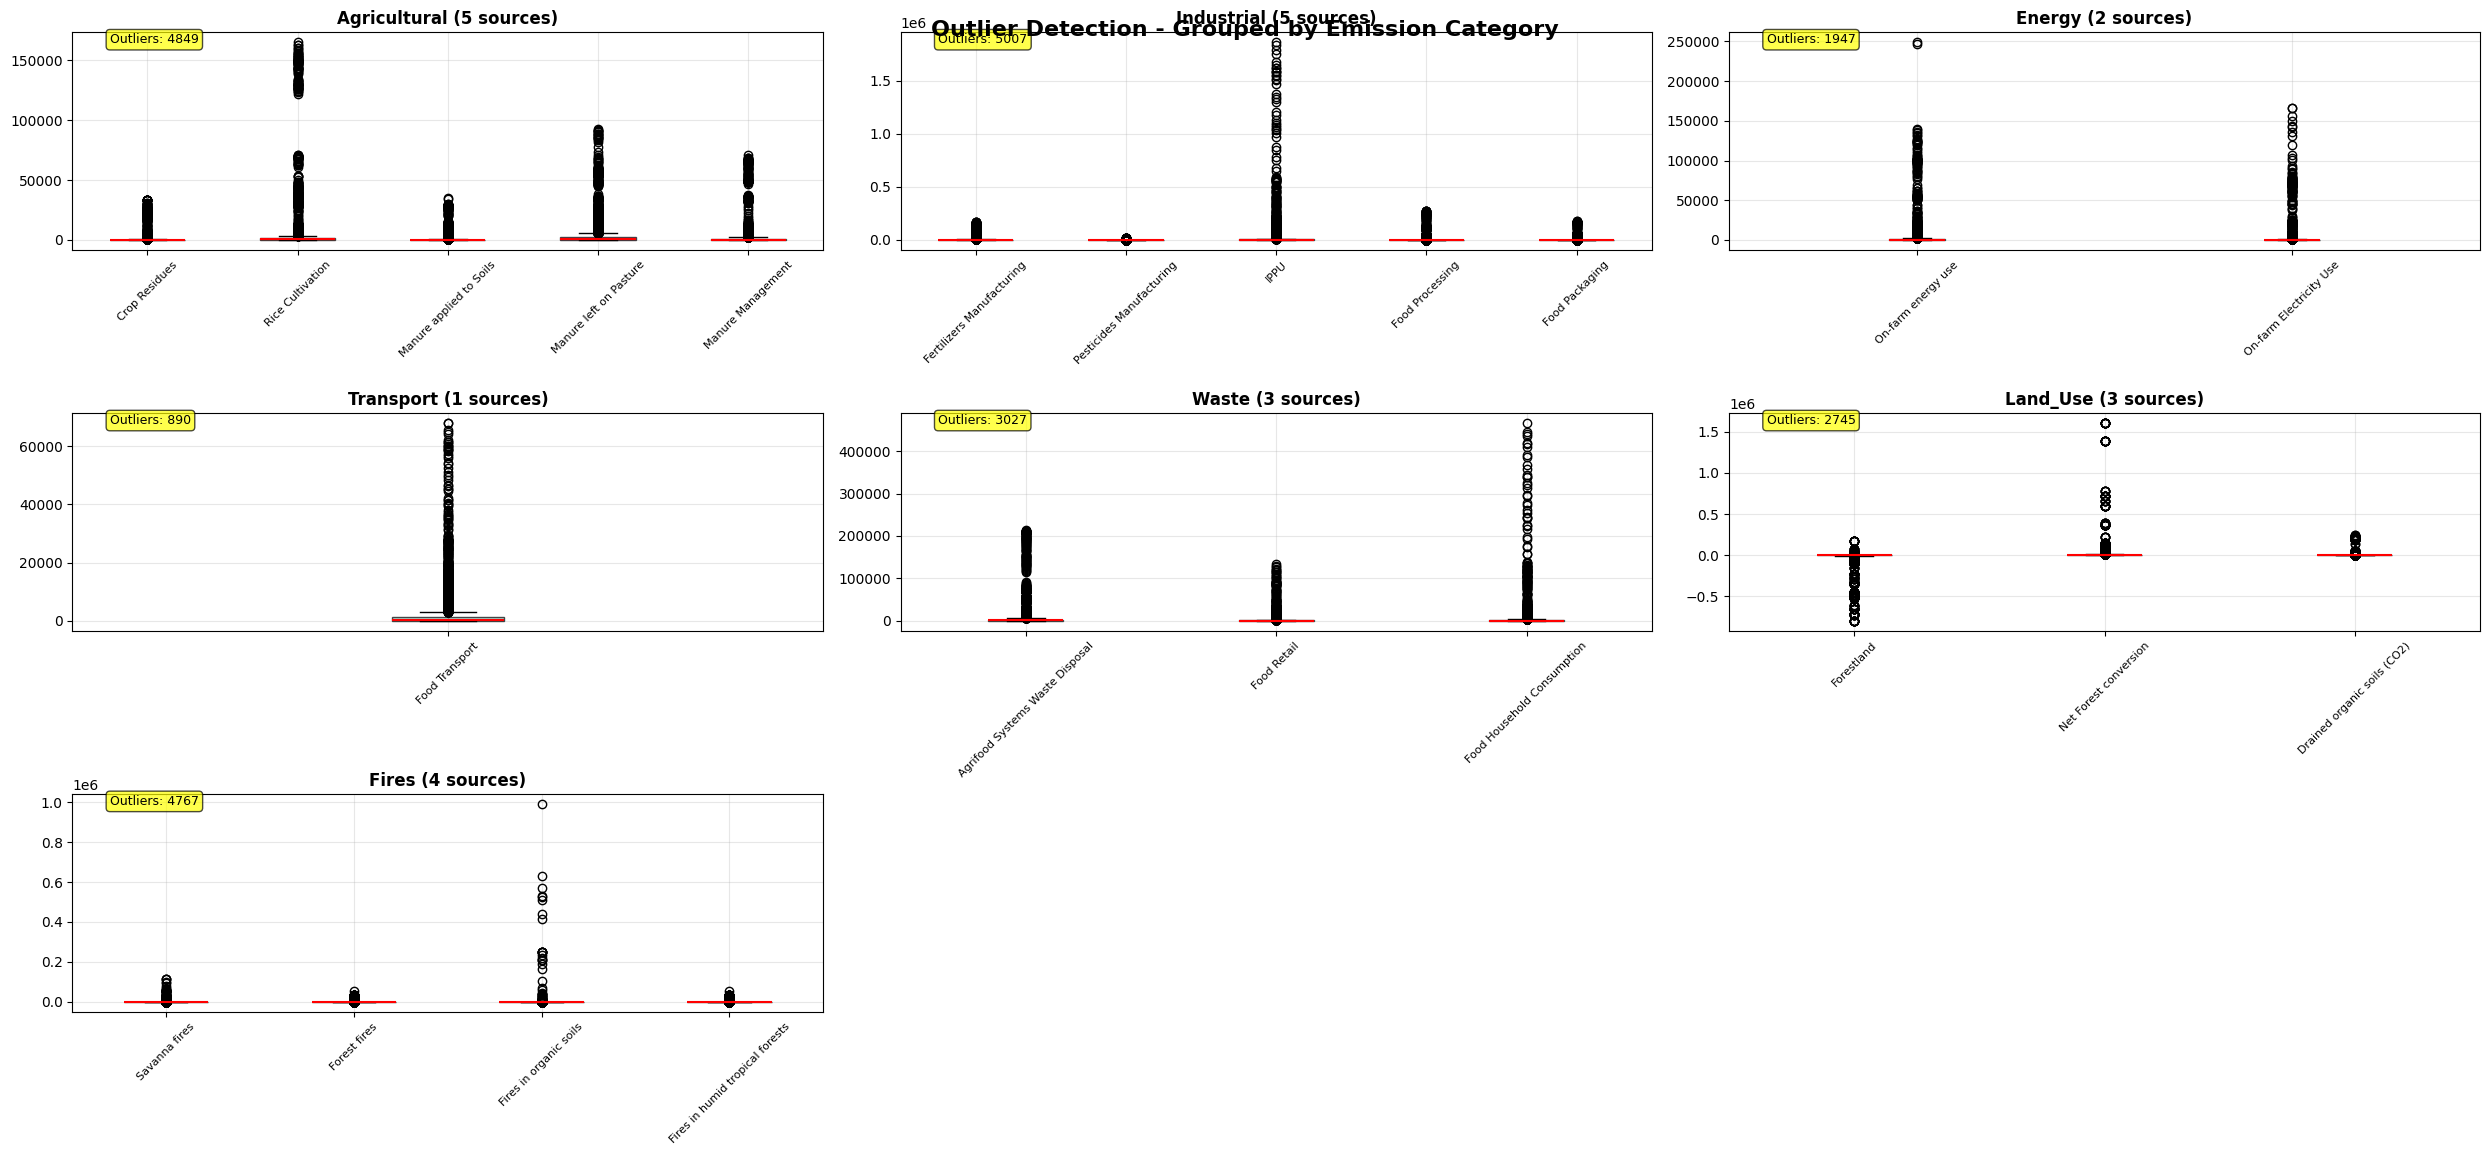


OUTLIER ANALYSIS SUMMARY
Total emission sources analyzed: 24
Total outliers detected: 24344

Top 5 emission sources with most outliers:
  1. Fires in humid tropical forests: 1607 outliers
  2. Savanna fires: 1439 outliers
  3. Forest fires: 1412 outliers
  4. Drained organic soils (CO2): 1361 outliers
  5. Food Packaging: 1358 outliers

Sources with no outliers: 0


In [ ]:
# Single boxplot visualization of outliers with shared axes
def visualize_outliers_single_boxplot(df_clean, figsize=(20, 10)):
    """Visualize outliers using a single boxplot for all emission columns with shared axes"""

    # Get emission columns (exclude non-emission columns)
    emission_columns = [col for col in df_clean.columns if col not in [
        'Area', 'Year', 'Average Temperature °C', 'Rural population',
        'Urban population', 'Total Population - Male', 'Total Population - Female',
        'total_population', 'urbanization_rate', 'industrial_emission',
        'industrial_emission_per_capita', 'emission_per_capita', 'period'
    ] and df_clean[col].dtype in ['float64', 'int64']]

    # Filter to only include columns with meaningful data (not all zeros/NaN)
    emission_columns = [col for col in emission_columns if df_clean[col].notna().sum() > 0 and df_clean[col].std() > 0]

    print(f"Plotting {len(emission_columns)} emission columns...")

    # Create single figure with one axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle('Outlier Detection - All Emission Columns (Shared Scale)',
                 fontsize=16, fontweight='bold', y=0.95)

    # Prepare data for boxplot
    plot_data = []
    labels = []
    outlier_counts = []

    for col in emission_columns:
        clean_data = df_clean[col].dropna()
        if len(clean_data) > 0:
            plot_data.append(clean_data)
            labels.append(col)

            # Calculate outliers for this column
            Q1 = clean_data.quantile(0.25)
            Q3 = clean_data.quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + 1.5 * IQR
            outliers = clean_data[clean_data > upper_bound]
            outlier_counts.append(len(outliers))

    # Create the boxplot
    boxplot = ax.boxplot(plot_data, labels=labels, patch_artist=True, showfliers=True)

    # Customize boxplot colors
    colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # Customize median lines
    for median in boxplot['medians']:
        median.set_color('red')
        median.set_linewidth(1.5)

    # Customize outlier points
    for flier in boxplot['fliers']:
        flier.set(marker='o', color='red', alpha=0.5, markersize=3)

    # Customize whiskers and caps
    for whisker in boxplot['whiskers']:
        whisker.set(color='black', linewidth=1)
    for cap in boxplot['caps']:
        cap.set(color='black', linewidth=1)

    # Add labels and formatting
    ax.set_ylabel('Emission Values (kt CO₂)', fontsize=12)
    ax.set_xlabel('Emission Sources', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')

    # Add legend for outlier counts
    legend_text = "\n".join([f"{label}: {count} outliers"
                           for label, count in zip(labels, outlier_counts) if count > 0])
    if legend_text:
        ax.text(0.02, 0.98, f"Outlier Counts:\n{legend_text}",
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=9)

    # Add summary statistics
    total_outliers = sum(outlier_counts)
    total_data_points = sum(len(data) for data in plot_data)
    outlier_percentage = (total_outliers / total_data_points) * 100

    ax.text(0.98, 0.02,
            f"Total Outliers: {total_outliers}\n"
            f"Total Data Points: {total_data_points}\n"
            f"Outlier %: {outlier_percentage:.2f}%",
            transform=ax.transAxes, verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
            fontsize=10)

    plt.tight_layout()
    plt.show()

    return labels, outlier_counts

# Alternative version with log scale for better visualization of wide-ranging data
def visualize_outliers_log_scale(df_clean, figsize=(20, 10)):
    """Visualize outliers using log scale for better comparison"""

    # Get emission columns
    emission_columns = [col for col in df_clean.columns if col not in [
        'Area', 'Year', 'Average Temperature °C', 'Rural population',
        'Urban population', 'Total Population - Male', 'Total Population - Female',
        'total_population', 'urbanization_rate', 'industrial_emission',
        'industrial_emission_per_capita', 'emission_per_capita', 'period'
    ] and df_clean[col].dtype in ['float64', 'int64']]

    # Filter columns and apply log transformation (adding 1 to avoid log(0))
    plot_data = []
    labels = []

    for col in emission_columns:
        clean_data = df_clean[col].dropna()
        if len(clean_data) > 0 and clean_data.min() >= 0:  # Only use non-negative data for log
            log_data = np.log1p(clean_data)  # log(1 + x) to handle zeros
            plot_data.append(log_data)
            labels.append(col)

    print(f"Plotting {len(plot_data)} emission columns (log scale)...")

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle('Outlier Detection - Emission Columns (Log Scale)',
                 fontsize=16, fontweight='bold', y=0.95)

    # Create boxplot
    boxplot = ax.boxplot(plot_data, labels=labels, patch_artist=True, showfliers=True)

    # Customize colors
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(plot_data)))
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in boxplot['medians']:
        median.set_color('darkred')
        median.set_linewidth(2)

    # Formatting
    ax.set_ylabel('Log(Emission Values + 1)', fontsize=12)
    ax.set_xlabel('Emission Sources', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

# Grouped boxplot version (by category)
def visualize_outliers_grouped(df_clean, figsize=(25, 12)):
    """Visualize outliers with grouped categories"""

    # Define emission categories
    categories = {
        'Agricultural': ['Crop Residues', 'Rice Cultivation', 'Manure applied to Soils',
                        'Manure left on Pasture', 'Manure Management'],
        'Industrial': ['Fertilizers Manufacturing', 'Pesticides Manufacturing', 'IPPU',
                     'Food Processing', 'Food Packaging'],
        'Energy': ['On-farm energy use', 'On-farm Electricity Use'],
        'Transport': ['Food Transport'],
        'Waste': ['Agrifood Systems Waste Disposal', 'Food Retail', 'Food Household Consumption'],
        'Land_Use': ['Forestland', 'Net Forest conversion', 'Drained organic soils (CO2)'],
        'Fires': ['Savanna fires', 'Forest fires', 'Fires in organic soils',
                 'Fires in humid tropical forests']
    }

    # Create subplots for each category
    n_categories = len(categories)
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Outlier Detection - Grouped by Emission Category',
                 fontsize=16, fontweight='bold', y=0.95)

    # Flatten axes if needed
    if n_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes] if n_cols == 1 else axes

    for idx, (category, columns) in enumerate(categories.items()):
        if idx < len(axes):
            # Get available data for this category
            available_cols = [col for col in columns if col in df_clean.columns and df_clean[col].notna().sum() > 0]

            if available_cols:
                plot_data = [df_clean[col].dropna() for col in available_cols]

                # Create boxplot for this category
                boxplot = axes[idx].boxplot(plot_data, labels=available_cols, patch_artist=True)

                # Customize
                colors = plt.cm.Set3(np.linspace(0, 1, len(available_cols)))
                for patch, color in zip(boxplot['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)

                for median in boxplot['medians']:
                    median.set_color('red')
                    median.set_linewidth(1.5)

                axes[idx].set_title(f'{category} ({len(available_cols)} sources)', fontsize=12, fontweight='bold')
                axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
                axes[idx].grid(True, alpha=0.3)

                # Add outlier count
                total_outliers = 0
                for data in plot_data:
                    Q1 = data.quantile(0.25)
                    Q3 = data.quantile(0.75)
                    IQR = Q3 - Q1
                    upper_bound = Q3 + 1.5 * IQR
                    outliers = data[data > upper_bound]
                    total_outliers += len(outliers)

                axes[idx].text(0.05, 0.95, f'Outliers: {total_outliers}',
                              transform=axes[idx].transAxes, fontsize=9,
                              bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
            else:
                axes[idx].text(0.5, 0.5, 'No data', transform=axes[idx].transAxes,
                              ha='center', va='center', fontsize=12)
                axes[idx].set_title(f'{category}', fontsize=12)

    # Hide empty subplots
    for idx in range(len(categories), len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

# Run the visualizations
print("Creating comprehensive outlier visualizations...")
print("=" * 60)

# 1. Single boxplot with all columns
labels, outlier_counts = visualize_outliers_single_boxplot(df_clean)

# 2. Log scale version (if needed)
visualize_outliers_log_scale(df_clean)

# 3. Grouped by category
visualize_outliers_grouped(df_clean)

# Print summary
print("\n" + "=" * 60)
print("OUTLIER ANALYSIS SUMMARY")
print("=" * 60)

total_outliers_all = sum(outlier_counts)
total_columns = len(labels)

print(f"Total emission sources analyzed: {total_columns}")
print(f"Total outliers detected: {total_outliers_all}")

# Top 5 sources with most outliers
if outlier_counts:
    outlier_summary = sorted(zip(labels, outlier_counts), key=lambda x: x[1], reverse=True)
    print("\nTop 5 emission sources with most outliers:")
    for i, (source, count) in enumerate(outlier_summary[:5], 1):
        print(f"  {i}. {source}: {count} outliers")

# Sources with no outliers
no_outlier_sources = [label for label, count in zip(labels, outlier_counts) if count == 0]
print(f"\nSources with no outliers: {len(no_outlier_sources)}")
if no_outlier_sources:
    print("Examples:", ", ".join(no_outlier_sources[:5]))

In [ ]:
#Changing every outlier to become the upper bound
def cap_outliers_to_upper_bound(df_clean):
    """Cap outliers to their upper bound values and return modified dataframe"""
    df_capped = df_clean.copy()
    emission_columns = [col for col in df_clean.columns if col not in ['Area', 'Year', 'Average Temperature °C', 'Rural population', 'Urban population', 'Total Population - Male', 'Total Population - Female']]

    capping_report = []

    for col in emission_columns:
        # Skip columns with no variation
        if df_capped[col].std() == 0:
            continue

        # Calculate IQR bounds
        Q1 = df_capped[col].quantile(0.25)
        Q3 = df_capped[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers before capping
        outliers_before = df_capped[df_capped[col] > upper_bound]
        outlier_count_before = len(outliers_before)

        # Cap outliers to upper bound
        df_capped[col] = np.where(df_capped[col] > upper_bound, upper_bound, df_capped[col])

        # Count outliers after capping
        outliers_after = df_capped[df_capped[col] > upper_bound]
        outlier_count_after = len(outliers_after)

        capping_report.append({
            'Column': col,
            'Upper_Bound': upper_bound,
            'Outliers_Before': outlier_count_before,
            'Outliers_After': outlier_count_after,
            'Max_Before': df_clean[col].max(),
            'Max_After': df_capped[col].max()
        })

    return df_capped, capping_report


We tried to handle the outlier, but after processing the data, it turns out that the outlier that has been handled are necessary for analysis, so we decided to keep the outlier as it is.

In [ ]:
countries_south_east_asia = ['Indonesia', 'Malaysia', 'Thailand', 'Singapore', 'Viet Nam', "Lao People's Democratic Republic", 'Brunei Darussalam', 'Myanmar', 'Cambodia', 'Philippines']
industrial_emission_sources = ['IPPU', 'Pesticides Manufacturing', 'Food Packaging', 'Food Processing', 'Fertilizers Manufacturing']

df_sea = df_clean[df_clean['Area'].isin(countries_south_east_asia)]

In [ ]:
# Calculate additional metrics
df_sea['total_population'] = df_sea['Rural population'] + df_sea['Urban population']
df_sea['urbanization_rate'] = (df_sea['Urban population'] / df_sea['total_population']) * 100
df_sea['emission_per_capita'] = df_sea['total_emission'] / (df_sea['total_population'] / 1e6)  # per million people

In [ ]:
# =============================================================================
# 1. WHAT: What is the total emission value from industrial sources in South East Asia (2010-2020)?
# =============================================================================
# Calculate total emissions by source for the period 2010-2020
recent_data = df_sea[df_sea['Year'] >= 2010]

source_totals = {}
for source in industrial_emission_sources:
    if source in recent_data.columns:
        source_totals[source] = recent_data[source].sum()

# Display results
print("Total emissions by source (2010-2020, kt CO₂):")
for source, total in sorted(source_totals.items(), key=lambda x: x[1], reverse=True):
    print(f"  {source}: {total:,.0f} kt")

total_emissions = recent_data['total_emission'].sum()
print(f"\nTotal emissions (all sources): {total_emissions:,.0f} kt")

Total emissions by source (2010-2020, kt CO₂):
  IPPU: 1,980,013 kt
  Food Processing: 410,840 kt
  Fertilizers Manufacturing: 257,394 kt
  Food Packaging: 98,265 kt
  Pesticides Manufacturing: 54,115 kt

Total emissions (all sources): 19,895,435 kt



 VISUALIZATION 1: WHAT - Industrial Emissions by Source


/tmp/ipython-input-1985029541.py:48: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


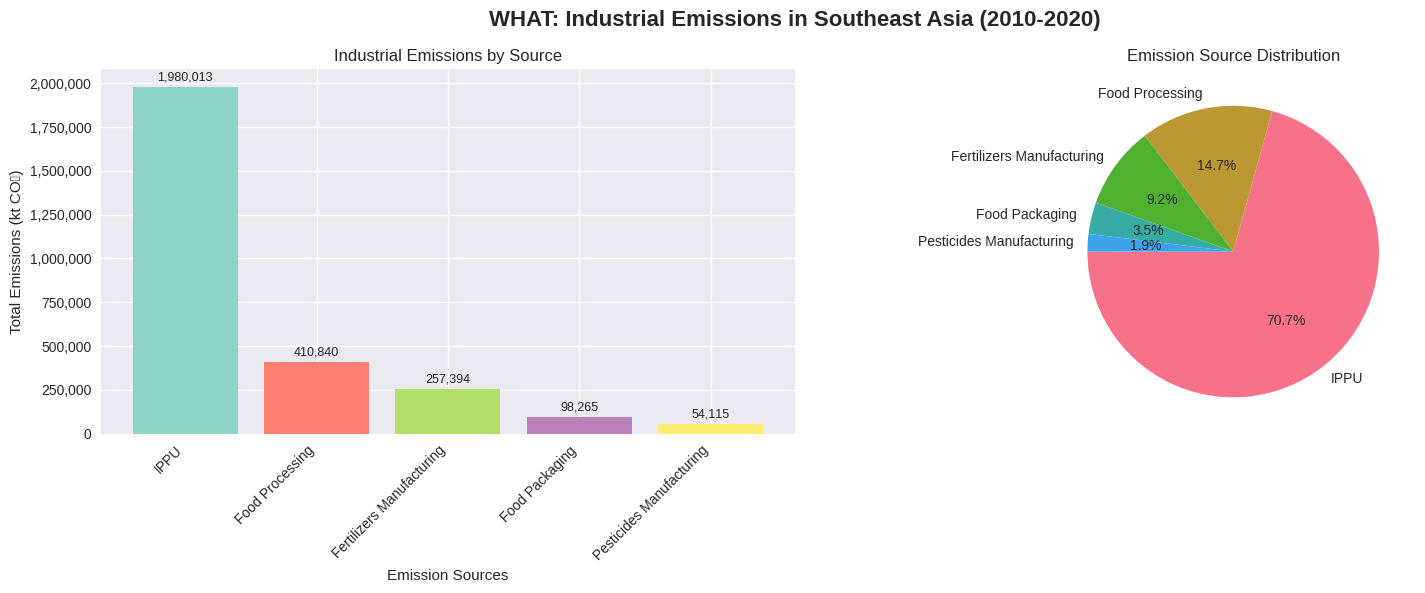

In [ ]:
from matplotlib.ticker import FuncFormatter

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Formatting function for large numbers
def format_large_numbers(x, pos):
    """Format numbers with comma separators"""
    return f'{x:,.0f}'

large_num_formatter = FuncFormatter(format_large_numbers)

# =============================================================================
# 1. WHAT: Visualization - Total Industrial Emissions by Source (2010-2020)
# =============================================================================

print("\n VISUALIZATION 1: WHAT - Industrial Emissions by Source")
print("="*60)

# Create figure for WHAT question
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig1.suptitle('WHAT: Industrial Emissions in Southeast Asia (2010-2020)', fontsize=16, fontweight='bold')

# Plot 1: Bar chart of emissions by source
sources_sorted = dict(sorted(source_totals.items(), key=lambda x: x[1], reverse=True))
sources_names = list(sources_sorted.keys())
sources_values = list(sources_sorted.values())

bars = ax1.bar(range(len(sources_sorted)), sources_values, color=plt.cm.Set3(np.linspace(0, 1, len(sources_sorted))))
ax1.set_title('Industrial Emissions by Source')
ax1.set_xlabel('Emission Sources')
ax1.set_ylabel('Total Emissions (kt CO₂)')
ax1.set_xticks(range(len(sources_sorted)))
ax1.set_xticklabels(sources_names, rotation=45, ha='right')
ax1.yaxis.set_major_formatter(large_num_formatter)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(sources_values)*0.01,
            f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Pie chart of emission distribution
ax2.pie(sources_values, labels=sources_names, autopct='%1.1f%%', startangle=180)
ax2.set_title('Emission Source Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# 2. WHEN: When did the urban population in South East Asia first surpass the rural population, and how did industrial emissions trend before and after that point?
# =============================================================================
# Agregasi total urban dan rural per tahun
pop_trend = df_sea.groupby('Year')[['Urban population', 'Rural population']].sum().reset_index()

# Temukan tahun pertama urban > rural
urban_surpass = pop_trend[pop_trend['Urban population'] > pop_trend['Rural population']]
if not urban_surpass.empty:
    turning_year = int(urban_surpass.iloc[0]['Year'])
    print(f"Urban population in Southeast Asia surpassed rural in: {turning_year}")
else:
    turning_year = None
    print("No year found where urban > rural in Southeast Asia.")

if turning_year:
    # Unpivot kolom emisi menjadi long format
    df_emission_long = df_sea.melt(
        id_vars=['Area', 'Year'],
        value_vars=industrial_emission_sources,
        var_name='source_name',
        value_name='emission_value'
    )

    # Tambahkan label period: before / after
    df_emission_long['period'] = df_emission_long['Year'].apply(
        lambda y: 'before' if y < turning_year else 'after'
    )

    # Agregasi total emisi industri per tahun
    emission_by_period = df_emission_long.groupby(['period', 'Year'])['emission_value'].sum().reset_index()

    # Ringkasan statistik
    summary = emission_by_period.groupby('period')['emission_value'].agg(['mean', 'sum', 'count']).round(2)
    print("\n Industrial Emission Summary:")
    print(summary)
else:
    print("Skipping emission trend — no turning year found.")


Urban population in Southeast Asia surpassed rural in: 2020

 Industrial Emission Summary:
             mean         sum  count
period                              
after   320345.62   320345.62      1
before  167748.76  5032462.67     30



 VISUALIZATION 2: WHEN - Urbanization Milestone & Emission Trends


/tmp/ipython-input-84600455.py:66: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


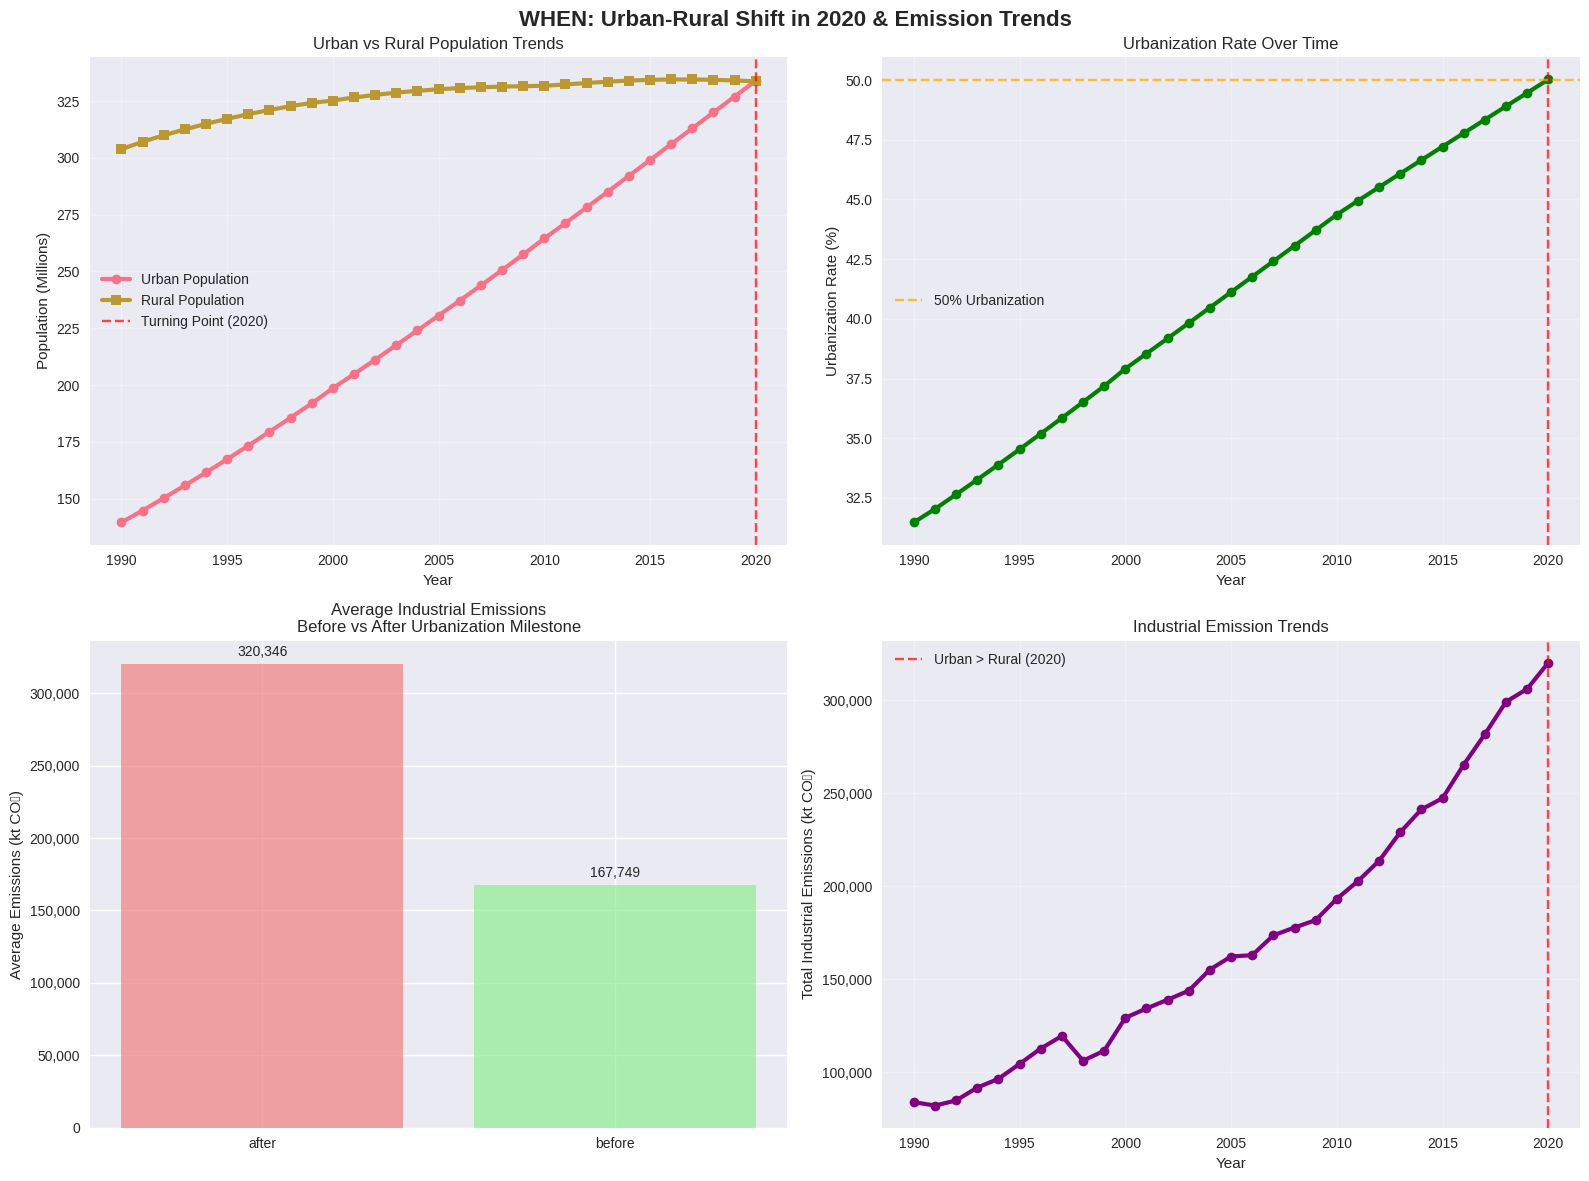

In [ ]:
# =============================================================================
# 2. WHEN: Visualization - Urban-Rural Shift and Emission Trends
# =============================================================================

print("\n VISUALIZATION 2: WHEN - Urbanization Milestone & Emission Trends")
print("="*60)

if turning_year:
    fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig2.suptitle(f'WHEN: Urban-Rural Shift in {turning_year} & Emission Trends', fontsize=16, fontweight='bold')

    # Plot 1: Urban vs Rural Population Trends
    ax1.plot(pop_trend['Year'], pop_trend['Urban population']/1e6,
             label='Urban Population', linewidth=3, marker='o')
    ax1.plot(pop_trend['Year'], pop_trend['Rural population']/1e6,
             label='Rural Population', linewidth=3, marker='s')
    ax1.axvline(x=turning_year, color='red', linestyle='--', alpha=0.7,
                label=f'Turning Point ({turning_year})')
    ax1.set_title('Urban vs Rural Population Trends')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Population (Millions)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(large_num_formatter)

    # Plot 2: Urbanization Rate Over Time
    pop_trend['Urbanization Rate'] = (pop_trend['Urban population'] /
                                    (pop_trend['Urban population'] + pop_trend['Rural population'])) * 100
    ax2.plot(pop_trend['Year'], pop_trend['Urbanization Rate'],
             linewidth=3, marker='o', color='green')
    ax2.axvline(x=turning_year, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(y=50, color='orange', linestyle='--', alpha=0.7, label='50% Urbanization')
    ax2.set_title('Urbanization Rate Over Time')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Urbanization Rate (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Industrial Emissions Before/After Turning Point
    period_data = emission_by_period.groupby('period')['emission_value'].mean()
    colors = ['lightcoral', 'lightgreen']
    bars = ax3.bar(period_data.index, period_data.values, color=colors, alpha=0.7)
    ax3.set_title('Average Industrial Emissions\nBefore vs After Urbanization Milestone')
    ax3.set_ylabel('Average Emissions (kt CO₂)')
    ax3.yaxis.set_major_formatter(large_num_formatter)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + max(period_data.values)*0.01,
                f'{height:,.0f}', ha='center', va='bottom')

    # Plot 4: Annual Emission Trends with Turning Point
    annual_emissions = df_emission_long.groupby('Year')['emission_value'].sum().reset_index()
    ax4.plot(annual_emissions['Year'], annual_emissions['emission_value'],
             linewidth=3, marker='o', color='purple')
    ax4.axvline(x=turning_year, color='red', linestyle='--', alpha=0.7,
                label=f'Urban > Rural ({turning_year})')
    ax4.set_title('Industrial Emission Trends')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Total Industrial Emissions (kt CO₂)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.yaxis.set_major_formatter(large_num_formatter)

    plt.tight_layout()
    plt.show()

In [ ]:
# =============================================================================
# 3. WHICH: Which country in South East Asia has the highest industrial emissions per capita (2010-2020)?
# =============================================================================
df_sea = df_clean[
    (df_clean['Area'].isin(countries_south_east_asia)) &
    (df_clean['Year'].between(2010, 2020))
].copy()


df_sea['total_population'] = df_sea['Urban population'] + df_sea['Rural population']
df_sea['industrial_emission'] = df_sea[industrial_emission_sources].sum(axis=1)
df_sea['emission_per_capita'] = df_sea['industrial_emission'] / (df_sea['total_population'])  # per million people


df_country_summary = df_sea.groupby('Area').agg({
    'industrial_emission': 'sum',
    'total_population': 'sum',
    'emission_per_capita': 'mean'  # bisa juga pakai total_emission / total_population
}).reset_index()

df_country_summary = df_country_summary.sort_values(by='emission_per_capita', ascending=False)
top_country = df_country_summary.iloc[0]

print("Highest Industrial Emissions per Capita (2000–2020) — Southeast Asia")
print(f" Country: {top_country['Area']}")
print(f" Total Industrial Emission: {top_country['industrial_emission']:,.0f} kt CO₂")
print(f" Total Population: {top_country['total_population']:,.0f}")
print(f" Emission per Capita: {top_country['emission_per_capita']:.2f} kt CO₂ per million people")

Highest Industrial Emissions per Capita (2000–2020) — Southeast Asia
🔹 Country: Brunei Darussalam
🔹 Total Industrial Emission: 66,490 kt CO₂
🔹 Total Population: 4,587,209
🔹 Emission per Capita: 0.01 kt CO₂ per million people


In [ ]:
df_grouped = df_sea.groupby('Area').agg({'emission_per_capita':'mean', 'total_population':'mean','industrial_emission': 'mean' }).reset_index()


 VISUALIZATION 3: WHICH - Industrial Emissions Per Capita


/tmp/ipython-input-3162026556.py:53: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  plt.tight_layout()


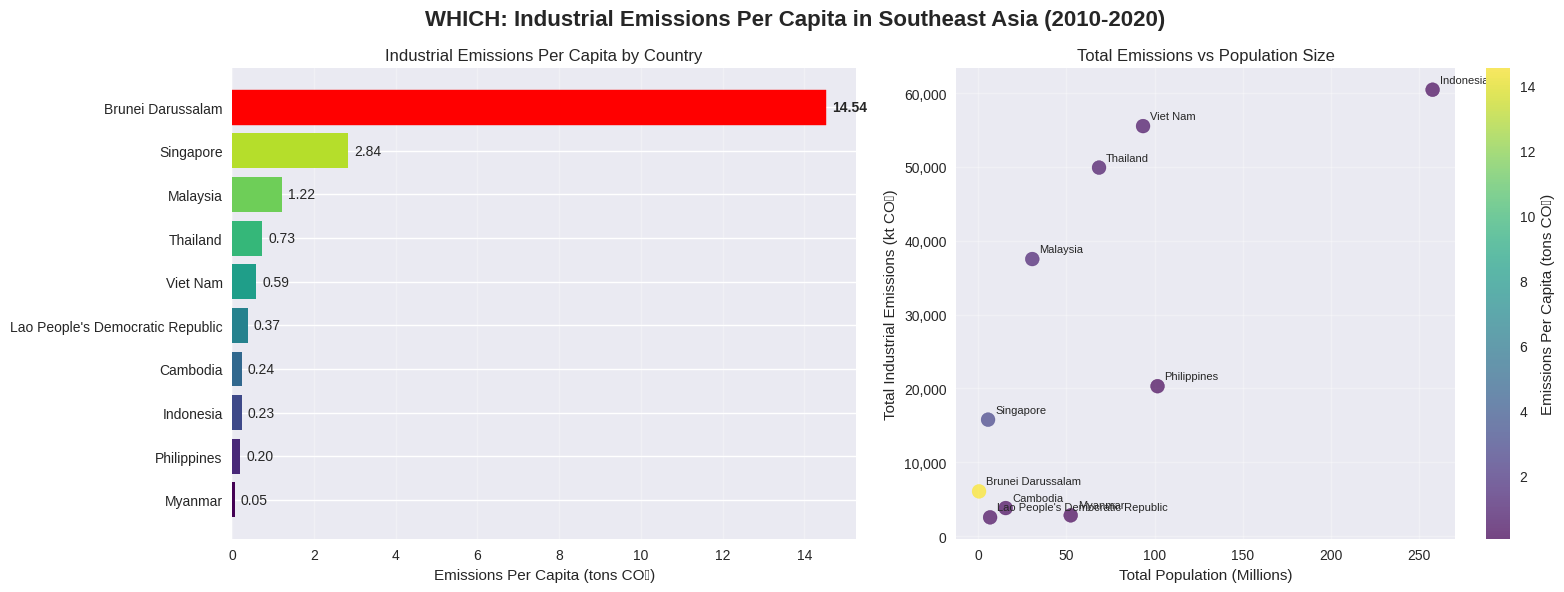


 TOP COUNTRY: Brunei Darussalam
   Emissions per capita: 14.54 tons CO₂/person
   Total emissions: 66,490 kt CO₂
   Population: 4,587,209


In [ ]:
# =============================================================================
# 3. WHICH: Visualization - Highest Industrial Emissions Per Capita
# =============================================================================

print("\n VISUALIZATION 3: WHICH - Industrial Emissions Per Capita")
print("="*60)

fig3, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig3.suptitle('WHICH: Industrial Emissions Per Capita in Southeast Asia (2010-2020)', fontsize=16, fontweight='bold')

# Plot 1: Emissions per capita by country (horizontal bar chart)
df_sorted = df_grouped.sort_values('emission_per_capita', ascending=True)
bars = ax1.barh(df_sorted['Area'], df_sorted['emission_per_capita'] * 1e3,  # Convert to tons for better readability
               color=plt.cm.viridis(np.linspace(0, 1, len(df_sorted))))

# Highlight the top country
top_country_idx = len(df_sorted) - 1
bars[top_country_idx].set_color('red')

ax1.set_title('Industrial Emissions Per Capita by Country')
ax1.set_xlabel('Emissions Per Capita (tons CO₂)')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + max(df_sorted['emission_per_capita'] * 1e3) * 0.01,
             bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', ha='left', va='center',
             fontweight='bold' if i == top_country_idx else 'normal')

# Plot 2: Total emissions vs Population scatter plot
scatter = ax2.scatter(df_grouped['total_population']/1e6, df_grouped['industrial_emission'],
                     s=100, alpha=0.7, c=df_grouped['emission_per_capita'] * 1e3,
                     cmap='viridis')
ax2.set_title('Total Emissions vs Population Size')
ax2.set_xlabel('Total Population (Millions)')
ax2.set_ylabel('Total Industrial Emissions (kt CO₂)')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(large_num_formatter)

# Add country labels
for i, country in enumerate(df_grouped['Area']):
    ax2.annotate(country,
                (df_grouped['total_population'].iloc[i]/1e6,
                 df_grouped['industrial_emission'].iloc[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Emissions Per Capita (tons CO₂)')

plt.tight_layout()
plt.show()

# Print top country info
print(f"\n TOP COUNTRY: {top_country['Area']}")
print(f"   Emissions per capita: {top_country['emission_per_capita'] * 1e3:.2f} tons CO₂/person")
print(f"   Total emissions: {top_country['industrial_emission']:,.0f} kt CO₂")
print(f"   Population: {top_country['total_population']:,.0f}")

In [ ]:
# =============================================================================
# 4. WHY: Why have industrial emissions in South East Asia increased significantly over the past decade?
# =============================================================================
# Filter data SEA & tahun 2010–2020
df_sea_decade = df_clean[
    (df_clean['Area'].isin(countries_south_east_asia)) &
    (df_clean['Year'].between(2010, 2020))
].copy()

# Tambahkan kolom total emisi industri
df_sea_decade['industrial_emission'] = df_sea_decade[industrial_emission_sources].sum(axis=1)

# Agregasi total emisi per tahun
emission_trend = df_sea_decade.groupby('Year')['industrial_emission'].sum().reset_index()

# Tampilkan tren
print(emission_trend.tail(20))

df_country_contrib = df_sea_decade.groupby('Area')['industrial_emission'].sum().sort_values(ascending=False)
print("Total Industrial Emission by Country (2010–2020):")
print(df_country_contrib)

    Year  industrial_emission
0   2010        193241.773346
1   2011        202787.447568
2   2012        213696.233340
3   2013        229077.041108
4   2014        241366.767343
5   2015        247398.375736
6   2016        265422.253611
7   2017        281808.449993
8   2018        299283.973137
9   2019        306200.042945
10  2020        320345.624628
Total Industrial Emission by Country (2010–2020):
Area
Indonesia                           664969.918400
Viet Nam                            610758.227100
Thailand                            548942.659400
Malaysia                            412663.743244
Philippines                         223208.876500
Singapore                           173368.166272
Brunei Darussalam                    66490.116335
Cambodia                             41638.885833
Myanmar                              30777.707200
Lao People's Democratic Republic     27809.682472
Name: industrial_emission, dtype: float64



 VISUALIZATION 4: WHY - Emission Growth Analysis


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


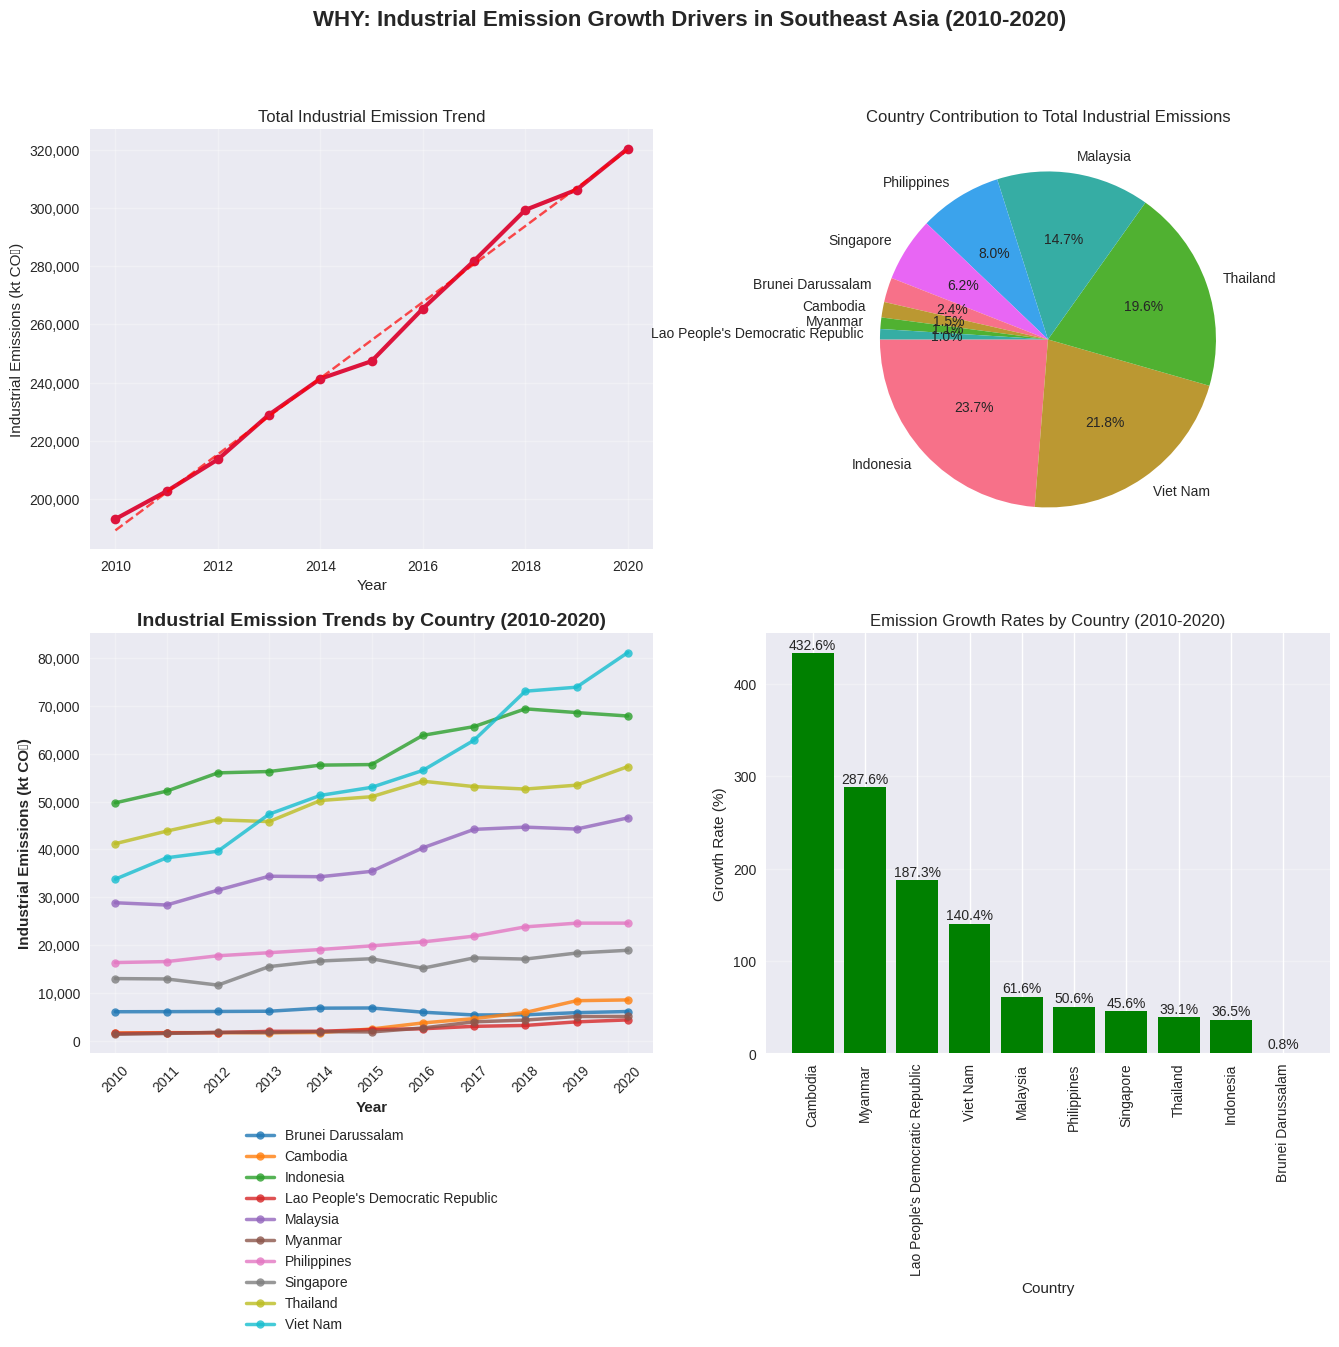

<Figure size 1200x800 with 0 Axes>

In [ ]:
# =============================================================================
# 4. WHY: Visualization - Emission Growth Drivers
# =============================================================================

print("\n VISUALIZATION 4: WHY - Emission Growth Analysis")
print("="*60)

fig4, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig4.suptitle('WHY: Industrial Emission Growth Drivers in Southeast Asia (2010-2020)', fontsize=16, fontweight='bold')

# Plot 1: Total Emission Trend Over Time
ax1.plot(emission_trend['Year'], emission_trend['industrial_emission'],
         linewidth=3, marker='o', color='crimson')
ax1.set_title('Total Industrial Emission Trend')
ax1.set_xlabel('Year')
ax1.set_ylabel('Industrial Emissions (kt CO₂)')
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(large_num_formatter)

# Calculate and plot trend line
z = np.polyfit(emission_trend['Year'], emission_trend['industrial_emission'], 1)
p = np.poly1d(z)
ax1.plot(emission_trend['Year'], p(emission_trend['Year']), "r--", alpha=0.7,
         label=f'Trend: {z[0]:.0f} kt/year')

# Plot 2: Country Contributions (Pie chart)
country_contrib_sorted = df_country_contrib.sort_values(ascending=False)
ax2.pie(country_contrib_sorted.values, labels=country_contrib_sorted.index,
        autopct='%1.1f%%', startangle=180)
ax2.set_title('Country Contribution to Total Industrial Emissions')

# Plot 3: Country-wise Emission Trends
# Create a color palette with good contrast
contrast_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5'
]

plt.figure(figsize=(12, 8))

countries = df_sea_decade['Area'].unique()

# Ensure we have enough colors
if len(countries) > len(contrast_colors):
    # Generate additional colors if needed
    import matplotlib.colors as mcolors
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    contrast_colors = base_colors * (len(countries) // len(base_colors) + 1)

for i, country in enumerate(countries):
    country_data = df_sea_decade[df_sea_decade['Area'] == country]
    country_trend = country_data.groupby('Year')['industrial_emission'].sum()

    # Use modulo to cycle through colors if we have more countries than colors
    color = contrast_colors[i % len(contrast_colors)]

    ax3.plot(country_trend.index, country_trend.values,
             marker='o', label=country, linewidth=2.5, color=color,
             markersize=6, alpha=0.8)

ax3.set_title('Industrial Emission Trends by Country (2010-2020)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year', fontweight='bold')
ax3.set_ylabel('Industrial Emissions (kt CO₂)', fontweight='bold')
ax3.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', framealpha=0.9)
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(large_num_formatter)

# Improve x-axis ticks to show all years
ax3.set_xticks(df_sea_decade['Year'].unique())
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Growth Rate Analysis
growth_rates = []
for country in df_sea_decade['Area'].unique():
    country_data = df_sea_decade[df_sea_decade['Area'] == country].sort_values('Year')
    if len(country_data) > 1:
        start_emission = country_data.iloc[0]['industrial_emission']
        end_emission = country_data.iloc[-1]['industrial_emission']
        growth_rate = ((end_emission - start_emission) / start_emission) * 100
        growth_rates.append({'Country': country, 'Growth_Rate': growth_rate})

growth_df = pd.DataFrame(growth_rates).sort_values('Growth_Rate', ascending=False)
bars = ax4.bar(growth_df['Country'], growth_df['Growth_Rate'],
              color=['green' if x >= 0 else 'red' for x in growth_df['Growth_Rate']])
ax4.set_title('Emission Growth Rates by Country (2010-2020)')
ax4.set_xlabel('Country')
ax4.set_ylabel('Growth Rate (%)')
ax4.tick_params(axis='x', rotation=90)
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + (1 if height >= 0 else -3),
             f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top')

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# 5. HOW: How can we quantify the correlation between the growth rate of urban population and the growth rate of industrial emissions in South East Asia countries?
# =============================================================================
# Filter data SEA dan tahun
df_sea = df_clean[
    (df_clean['Area'].isin(countries_south_east_asia)) &
    (df_clean['Year'].between(2010, 2020))
].copy()

# Tambahkan kolom total emisi industri
df_sea['industrial_emission'] = df_sea[industrial_emission_sources].sum(axis=1)

correlations = []

for country in df_sea['Area'].unique():
    df_country = df_sea[df_sea['Area'] == country].sort_values(by='Year').copy()

    # Hitung % growth rate tahunan
    df_country['urban_growth'] = df_country['Urban population'].pct_change()
    df_country['emission_growth'] = df_country['industrial_emission'].pct_change()

    # Drop NaN
    df_cleaned = df_country.dropna(subset=['urban_growth', 'emission_growth'])

    # Hitung korelasi Pearson
    if not df_cleaned.empty:
        corr = df_cleaned['urban_growth'].corr(df_cleaned['emission_growth'])
        correlations.append({
            'Country': country,
            'Correlation': round(corr, 4),
            'Avg Urban Growth (%)': round(df_cleaned['urban_growth'].mean() * 100, 2),
            'Avg Emission Growth (%)': round(df_cleaned['emission_growth'].mean() * 100, 2),
        })

df_corr = pd.DataFrame(correlations).sort_values(by='Correlation', ascending=False)

print("📊 Correlation Between Urban Population Growth and Industrial Emission Growth (2010–2020):")
print(df_corr)

📊 Correlation Between Urban Population Growth and Industrial Emission Growth (2010–2020):
                            Country  Correlation  Avg Urban Growth (%)  \
2                         Indonesia       0.3484                  2.45   
8                          Thailand       0.2641                  1.93   
5                           Myanmar       0.1320                  1.65   
9                          Viet Nam       0.1244                  3.16   
3  Lao People's Democratic Republic       0.1103                  3.31   
4                          Malaysia       0.0854                  2.44   
0                 Brunei Darussalam       0.0037                  1.79   
7                         Singapore      -0.0663                  1.58   
6                       Philippines      -0.1917                  2.04   
1                          Cambodia      -0.3652                  3.38   

   Avg Emission Growth (%)  
2                     3.23  
8                     3.43  
5       


 VISUALIZATION 5: HOW - Urban vs Emission Growth Correlation


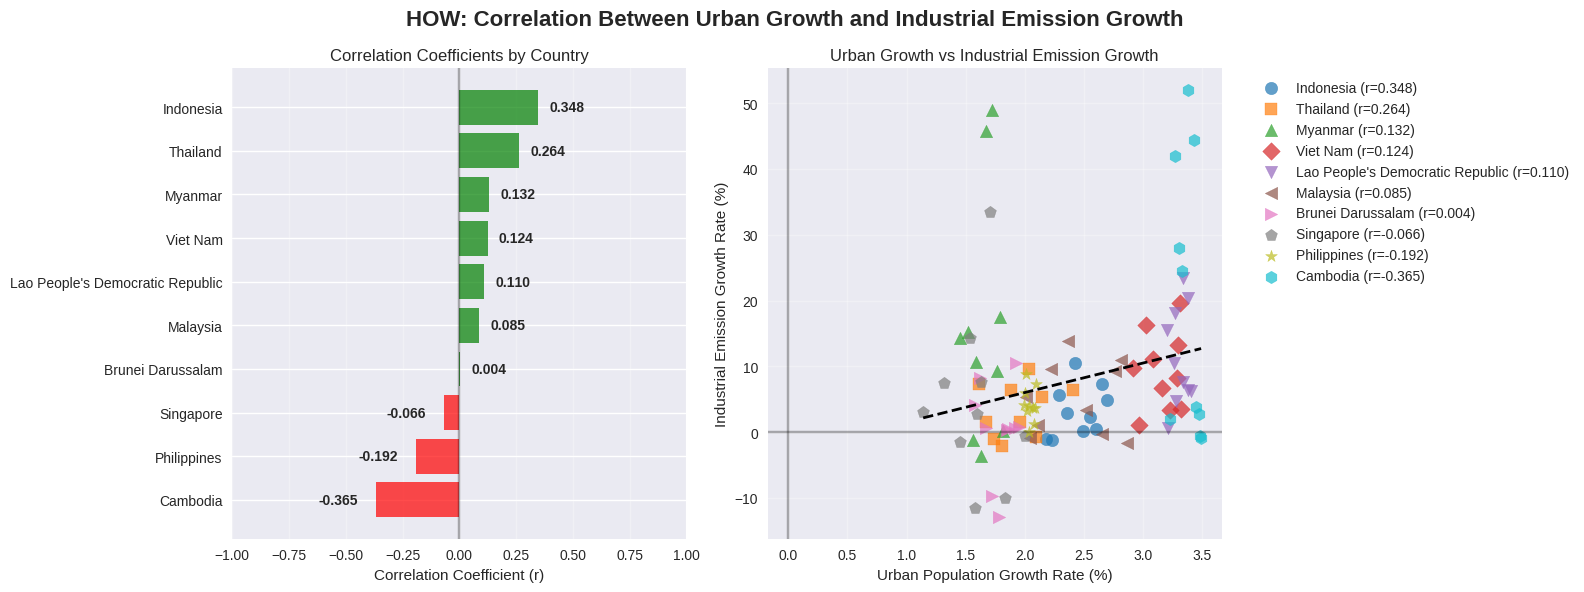

In [ ]:
# =============================================================================
# 5. HOW: Visualization - Urban Growth vs Emission Growth Correlation
# =============================================================================

print("\n VISUALIZATION 5: HOW - Urban vs Emission Growth Correlation")
print("="*60)

fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig5.suptitle('HOW: Correlation Between Urban Growth and Industrial Emission Growth', fontsize=16, fontweight='bold')

# Plot 1: Correlation coefficients by country
df_corr_sorted = df_corr.sort_values('Correlation', ascending=True)
colors = ['red' if x < 0 else 'green' for x in df_corr_sorted['Correlation']]
bars = ax1.barh(df_corr_sorted['Country'], df_corr_sorted['Correlation'], color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1.set_title('Correlation Coefficients by Country')
ax1.set_xlabel('Correlation Coefficient (r)')
ax1.set_xlim(-1, 1)
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax1.text(width + 0.05 if width >= 0 else width - 0.08,
             bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left' if width >= 0 else 'right', va='center',
             fontweight='bold')

# Plot 2: Scatter plots for each country
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
colors = plt.cm.tab10(np.linspace(0, 1, len(df_corr)))

for idx, country in enumerate(df_corr['Country']):
    country_data = df_sea[df_sea['Area'] == country].sort_values('Year').copy()
    country_data['urban_growth'] = country_data['Urban population'].pct_change() * 100
    country_data['emission_growth'] = country_data['industrial_emission'].pct_change() * 100
    country_clean = country_data.dropna(subset=['urban_growth', 'emission_growth'])

    if not country_clean.empty:
        ax2.scatter(country_clean['urban_growth'], country_clean['emission_growth'],
                   label=f"{country} (r={df_corr[df_corr['Country']==country]['Correlation'].values[0]:.3f})",
                   marker=markers[idx % len(markers)], color=colors[idx], s=80, alpha=0.7)

ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax2.set_title('Urban Growth vs Industrial Emission Growth')
ax2.set_xlabel('Urban Population Growth Rate (%)')
ax2.set_ylabel('Industrial Emission Growth Rate (%)')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Add overall correlation line if enough data points
all_growth_data = []
for country in df_sea['Area'].unique():
    country_data = df_sea[df_sea['Area'] == country].sort_values('Year').copy()
    country_data['urban_growth'] = country_data['Urban population'].pct_change() * 100
    country_data['emission_growth'] = country_data['industrial_emission'].pct_change() * 100
    country_clean = country_data.dropna(subset=['urban_growth', 'emission_growth'])
    if not country_clean.empty:
        all_growth_data.append(country_clean)

if all_growth_data:
    combined_data = pd.concat(all_growth_data, ignore_index=True)
    if len(combined_data) > 2:
        z = np.polyfit(combined_data['urban_growth'], combined_data['emission_growth'], 1)
        x_range = np.linspace(combined_data['urban_growth'].min(), combined_data['urban_growth'].max(), 100)
        ax2.plot(x_range, np.poly1d(z)(x_range), 'k--', linewidth=2,
                label=f'Overall Trend (r={combined_data["urban_growth"].corr(combined_data["emission_growth"]):.3f})')

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# Descriptive Statistics
# =============================================================================
print("\n DESCRIPTIVE STATISTICS - Total Emissions")
print("-" * 40)

desc_stats = df_sea['total_emission'].describe()
print(desc_stats)

# Additional distribution metrics
skewness = skew(df_sea['total_emission'])
kurt = kurtosis(df_sea['total_emission'])

print(f"\nDistribution Shape:")
print(f"Skewness: {skewness:.3f} ({'Moderately' if abs(skewness) > 0.5 else 'Slightly'} {'right' if skewness > 0 else 'left'} skewed)")
print(f"Kurtosis: {kurt:.3f} ({'Leptokurtic' if kurt > 0 else 'Platykurtic'})")


DESCRIPTIVE STATISTICS - Total Emissions
----------------------------------------
count    1.100000e+02
mean     1.808676e+05
std      2.996443e+05
min     -5.278728e+04
25%      2.184408e+04
50%      9.799770e+04
75%      1.783216e+05
max      1.444640e+06
Name: total_emission, dtype: float64

Distribution Shape:
Skewness: 2.751 (Moderately right skewed)
Kurtosis: 6.888 (Leptokurtic)


The skewness tells us that industrial emissions in Southeast Asia are unevenly distributed - a small number of larger/industrialized economies account for a disproportionate share of total emissions. The kurtosis further sugessted that most countries cluster around similar emission levels (the peak) But there are more extreme cases than expected (some countries with unusually high emissions and some with unusually low emissions)

This suggests distinct emission profiles among Southeast Asian nations

In [ ]:
# =============================================================================
# T-test: Early vs Late Period (Using Available Data)
# =============================================================================
print("\nT-TEST: Emissions 2010-2012 vs 2018-2020")
print("-" * 40)

early_emissions = df_sea[df_sea['Year'].between(2010, 2012)]['total_emission']
late_emissions = df_sea[df_sea['Year'].between(2018, 2020)]['total_emission']

if len(early_emissions) == 0 or len(late_emissions) == 0:
    print("❌ ERROR: No data found for the specified periods!")
else:
    t_stat, p_value = ttest_ind(early_emissions, late_emissions, equal_var=False)

    print(f"Early period (2010-2012): n={len(early_emissions)}, mean={early_emissions.mean():.0f} kt")
    print(f"Late period (2018-2020): n={len(late_emissions)}, mean={late_emissions.mean():.0f} kt")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")
    print(f"Significant difference: {'YES' if p_value < 0.05 else 'NO'}")


T-TEST: Emissions 2010-2012 vs 2018-2020
----------------------------------------
Early period (2010-2012): n=30, mean=159096 kt
Late period (2018-2020): n=30, mean=194810 kt
T-statistic: -0.494, P-value: 0.6232
Significant difference: NO


In [ ]:
# =============================================================================
# ANOVA: Differences between countries
# =============================================================================
print("\n ANOVA: Emission Differences Between Countries")
print("-" * 40)

# Prepare data for ANOVA
country_groups = []
for country in df_sea['Area'].unique():
    country_emissions = df_sea[df_sea['Area'] == country]['total_emission']
    country_groups.append(country_emissions)

f_stat, p_value = stats.f_oneway(*country_groups)

print(f"One-way ANOVA - Total emissions by country:")
print(f"F-statistic: {f_stat:.3f}, P-value: {p_value:.4f}")
print(f"Significant differences between countries: {'YES' if p_value < 0.05 else 'NO'}")


ANOVA: Emission Differences Between Countries
----------------------------------------
One-way ANOVA - Total emissions by country:
F-statistic: 113.486, P-value: 0.0000
Significant differences between countries: YES


the anova test result suggest there are stark difference between emission from each countries

In [ ]:
# =============================================================================
# Correlation Analysis: Urbanization vs Emissions
# =============================================================================
print("\n CORRELATION ANALYSIS: Urbanization vs Emissions")
print("-" * 50)

from scipy.stats import pearsonr, spearmanr

# Calculate different correlation coefficients
pearson_corr, pearson_p = pearsonr(
    df_sea['urbanization_rate'],
    df_sea['total_emission']
)

spearman_corr, spearman_p = spearmanr(
    df_sea['urbanization_rate'],
    df_sea['total_emission']
)

print("Correlation Analysis Results:")
print(f"Pearson Correlation (r): {pearson_corr:.3f}")
print(f"Spearman Rank Correlation (ρ): {spearman_corr:.3f}")
print(f"Pearson P-value: {pearson_p:.4f}")
print(f"Spearman P-value: {spearman_p:.4f}")

# Interpret the correlation strength
def interpret_correlation(r):
    abs_r = abs(r)
    if abs_r >= 0.9:
        return "very strong"
    elif abs_r >= 0.7:
        return "strong"
    elif abs_r >= 0.5:
        return "moderate"
    elif abs_r >= 0.3:
        return "weak"
    else:
        return "very weak"

print(f"\n Interpretation:")
print(f"• Pearson: {interpret_correlation(pearson_corr)} {'positive' if pearson_corr > 0 else 'negative'} linear relationship")
print(f"• Spearman: {interpret_correlation(spearman_corr)} {'positive' if spearman_corr > 0 else 'negative'} monotonic relationship")
print(f"• Statistical significance: {'Yes' if pearson_p < 0.05 else 'No'} (p < 0.05)")

# Additional: Country-level correlations
print(f"\n Country-specific Analysis:")
country_correlations = []
for country in df_sea['Area'].unique():
    country_data = df_sea[df_sea['Area'] == country]
    if len(country_data) > 2:  # Need at least 3 points for correlation
        corr, p_val = pearsonr(
            country_data['urbanization_rate'],
            country_data['total_emission']
        )
        country_correlations.append({
            'country': country,
            'correlation': corr,
            'p_value': p_val,
            'significant': p_val < 0.05
        })

# Sort by absolute correlation strength
country_correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)

print(f"Top 3 strongest country-level correlations:")
for i, result in enumerate(country_correlations[:3]):
    sig_symbol = "✅" if result['significant'] else "❌"
    print(f"  {i+1}. {result['country']}: r = {result['correlation']:.3f} {sig_symbol}")


 CORRELATION ANALYSIS: Urbanization vs Emissions
--------------------------------------------------
Correlation Analysis Results:
Pearson Correlation (r): -0.082
Spearman Rank Correlation (ρ): -0.271
Pearson P-value: 0.3921
Spearman P-value: 0.0042

 Interpretation:
• Pearson: very weak negative linear relationship
• Spearman: very weak negative monotonic relationship
• Statistical significance: No (p < 0.05)

 Country-specific Analysis:
Top 3 strongest country-level correlations:
  1. Philippines: r = 0.986 ✅
  2. Malaysia: r = 0.543 ❌
  3. Brunei Darussalam: r = -0.441 ❌


/tmp/ipython-input-3722276266.py:51: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val = pearsonr(


If you look at the pearson and spearman correlation all Southeast Asian countries together, there's essentially no consistent pattern between how urbanized a country is and how much it emits. Spearman correlation detects monotonic relationships (consistently increasing/decreasing), while Pearson detects linear relationships. The significant Spearman but insignificant Pearson suggests there might be some consistent pattern, but it's not a straight-line relationship. Urbanization affects emissions differently in each country, factors like industrial structure, energy sources, and environmental policies likely explain why patterns differ.